Final Project Report: Predicting a High Contributer 
-

In [25]:
library(tidymodels)
library(tidyverse)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




## I. Introduction
#### Background:
Online gaming communities rely heavily on consistent player engagement to stay active, collaborative, and enjoyable. Some players are highly active and frequently participate in server-wide activities while other more casual players prefer to play or interact far less frequently. Understanding what factors influence a player's activity level can help developers improve user experience and strengthen player retention. In this project, we will be investigating how player characteristics such as age, experience, and subscription attribute to higher levels of engagement in the server. In our analysis, we will explore the dataset, `players.csv`, which contains information on player demographics, experience, engagement, and amount of time spent on the server. Our goal is to better understand the trends within this data and use these factors to build a predictive model which predicts whether a player is likely to be a high or low contributor to the server. 


#### Question:
Can player characteristics (specifically `experience`, `gender`, `subscribe`, and `Age`) predict whether a player is a high data contributor (defined as having `played_hours` in the top 75th percentile) in the `players` dataset?

#### Why `players.csv`?
Although the full dataset includes both `players.csv` and `sessions.csv`, the `players` dataset would be the best choice for our question. `sessions.csv` only contains information on individual play sessions with each row representing a session's player and duration of play. However, it does not include any player characteristics or demographics. Since our question of interest involves predicting which types of players are most likely to be high contributors based off player characteristics, we must use the dataset that actually contains these characteristics.


#### Data Description:
The `players` dataset contains data on player demographics, information, and engagement and has 196 observations and 7 variables.
| Variable Name |   Data Type   |                                 Meaning                                |
|:-------------:|:-------------:|:----------------------------------------------------------------------:|
|  experience   |   Character   |              A player’s self-reported experience level                 |
|  subscribe    |    Logical    |   Whether a player is subscribed to a game-related newsletter or not   |
|  hashedEmail  |   Character   |                             Hashed player email                        |
|  played_hours |    Double     |                      Total hours spent playing on server               |
|      name     |   Character   |                             Player's name                              |
|     gender    |   Character   |                            Player's gender                             |
|      Age      |    Double     |                        Player's age in years                           | 


#### Potential Issues:
- Most of the data in the `players` dataset comes from survey results so bias, exaggeration, or inaccuracy may be present.
- Missing values appear in some of the variables, including `gender` and `Age`
- The `experience` variable in `players.csv` is very subjective, and is more likely an indicator of how confident the player is, rather than an actual measure of their actual skill level.
- Most entries are less than `25 played_hours` with many zeroes, but there are several outliers that are well above 150. These outliers should be included in our analysis; however, they may make reading certain plots very difficult.
- `Age` could easily be fabricated.


## II. Methods & Results
#### Overall Process & Determining Which Variables to Use:
There are several variables available for building our KNN classification model, but it is important to thoroughly analyze each one to ensure it meets all assumptions required for KNN classification and whether it is relevant. To do this, we will do some exploratory analysis through visualizations. After selecting and deciding on the best predictors, we will then create a prediction model, using K-nearest neigbors, and evaluate its performance on the unseen test data using the optimal value for K.

First, we will need to view and load the datasets. Both appear to use a "," delimter, so read_csv will be the most appropriate option to use. 

In [12]:
players <- read_csv("https://raw.githubusercontent.com/Modas101/dsci-100-project-final/refs/heads/main/data/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


There are some missing values in the `players` dataset, mainly in the `Age` variable. Since age is a predictor we intend to use, observations with missing age cannot be included. To classify players as *high contributors*, we defined a threshold: the top 25% of players would be considered as top contributors. We did some wrangling to calculate the minimum playtime to qualify as a high contributor and to create the `high_contributors` variable, labelling all players with playtime meeting or exceeding this threshold as high contributors. 

In [16]:
clean_players <- players |>
    filter(!is.na(Age))

played_hours_75th_percentile <- clean_players |>
    pull(played_hours) |>
    quantile(0.75)
played_hours_75th_percentile

clean_players <- clean_players |>
    mutate(high_contributor = played_hours > played_hours_75th_percentile)
head(clean_players)

75% 
0.6

experience,subscribe,hashedEmail,played_hours,name,gender,Age,high_contributor
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,TRUE
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,TRUE
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,FALSE
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,TRUE
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,FALSE
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,FALSE


We then plotted histograms showing the proportion of high-contribution players to `Age`, `experience`, and `subscribe`. These graphs help us visualize patterns present within the data, so we can choose which variables to include in our knn classification model. 

Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_bar()`).”


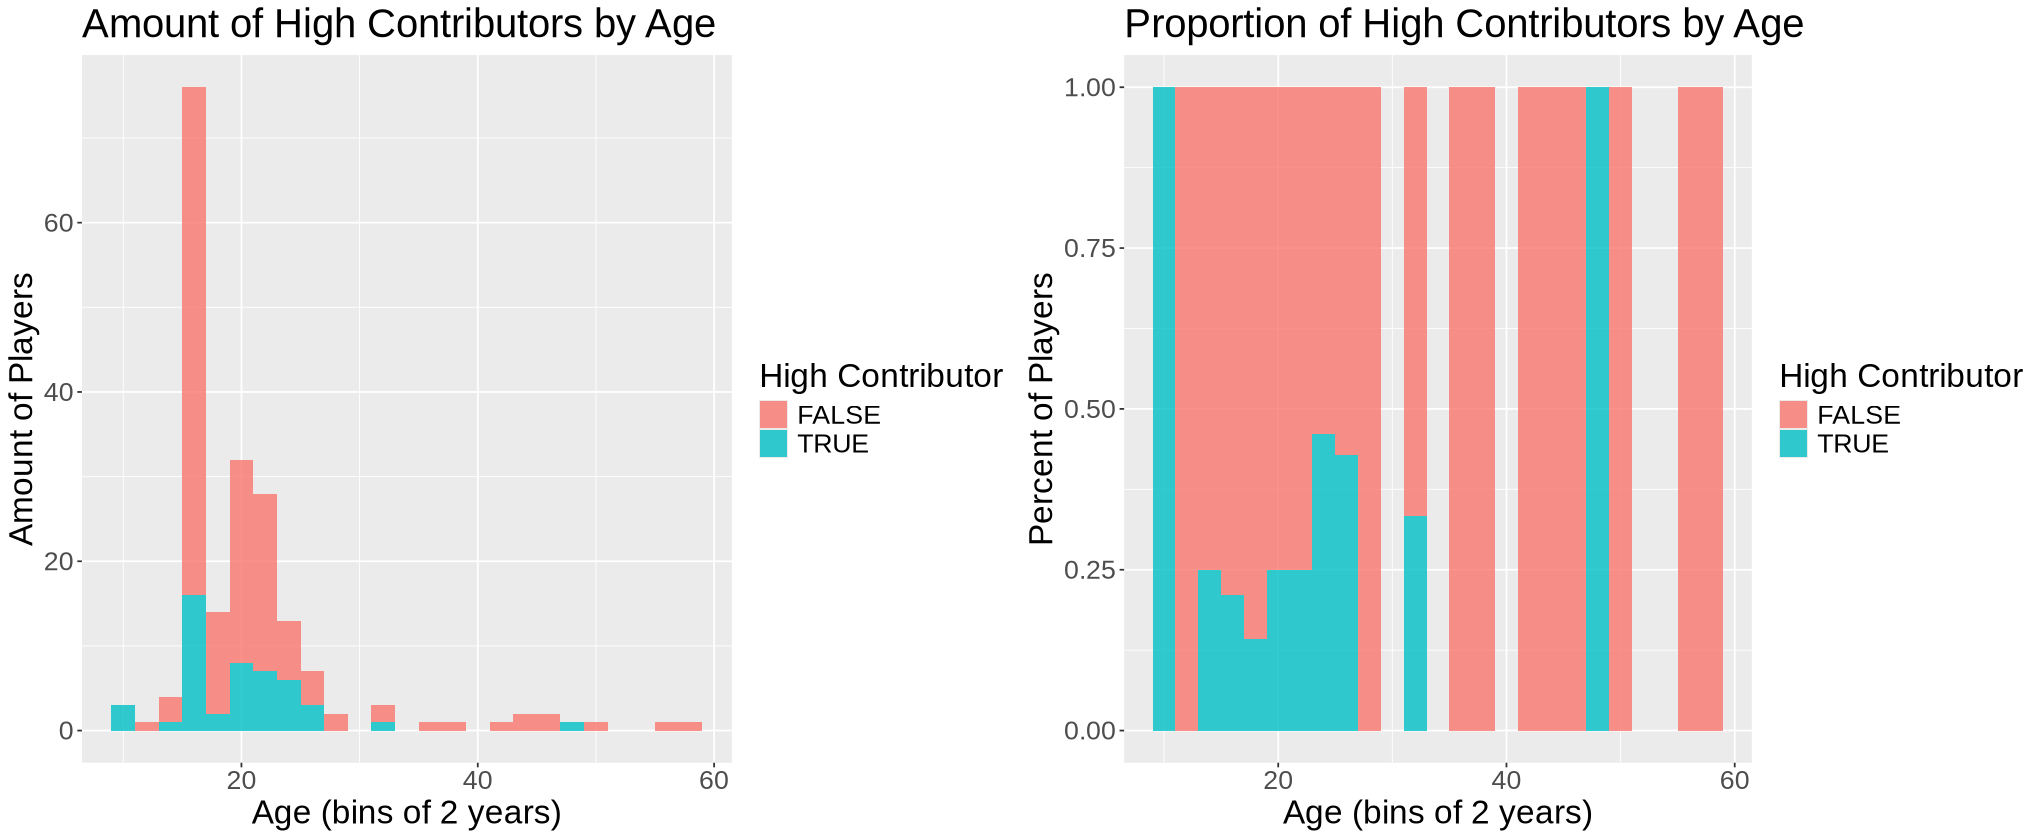

In [34]:
options(repr.plot.width = 17, repr.plot.height = 7)

amt_age_high_contrib <- clean_players |> 
    ggplot(aes(x = Age, fill = high_contributor)) +
        geom_histogram(binwidth = 2, position = "stack", alpha = 0.8) +
        labs(title = "Amount of High Contributors by Age",
            x = "Age (bins of 2 years)",
            y = "Amount of Players",
            fill = "High Contributor") + 
        theme(text = element_text(size = 20))
#amt_age_high_contrib

prop_age_high_contrib <- clean_players |> 
    ggplot(aes(x = Age, fill = high_contributor)) +
        geom_histogram(binwidth = 2, position = "fill", alpha = 0.8) +
        labs(title = "Proportion of High Contributors by Age",
            x = "Age (bins of 2 years)",
            y = "Percent of Players",
            fill = "High Contributor") + 
        theme(text = element_text(size = 20))
#prop_age_high_contrib

plot_grid(amt_age_high_contrib, prop_age_high_contrib)

The two graphs above show the amount and proportion of high contributors by age. The distribution appears to be far concentrated between younger ages (15-25 years old). Outside this range, older ages only appear a few times. Most of the high contributors also seem to be younger, representative of the higher number of younger players. 

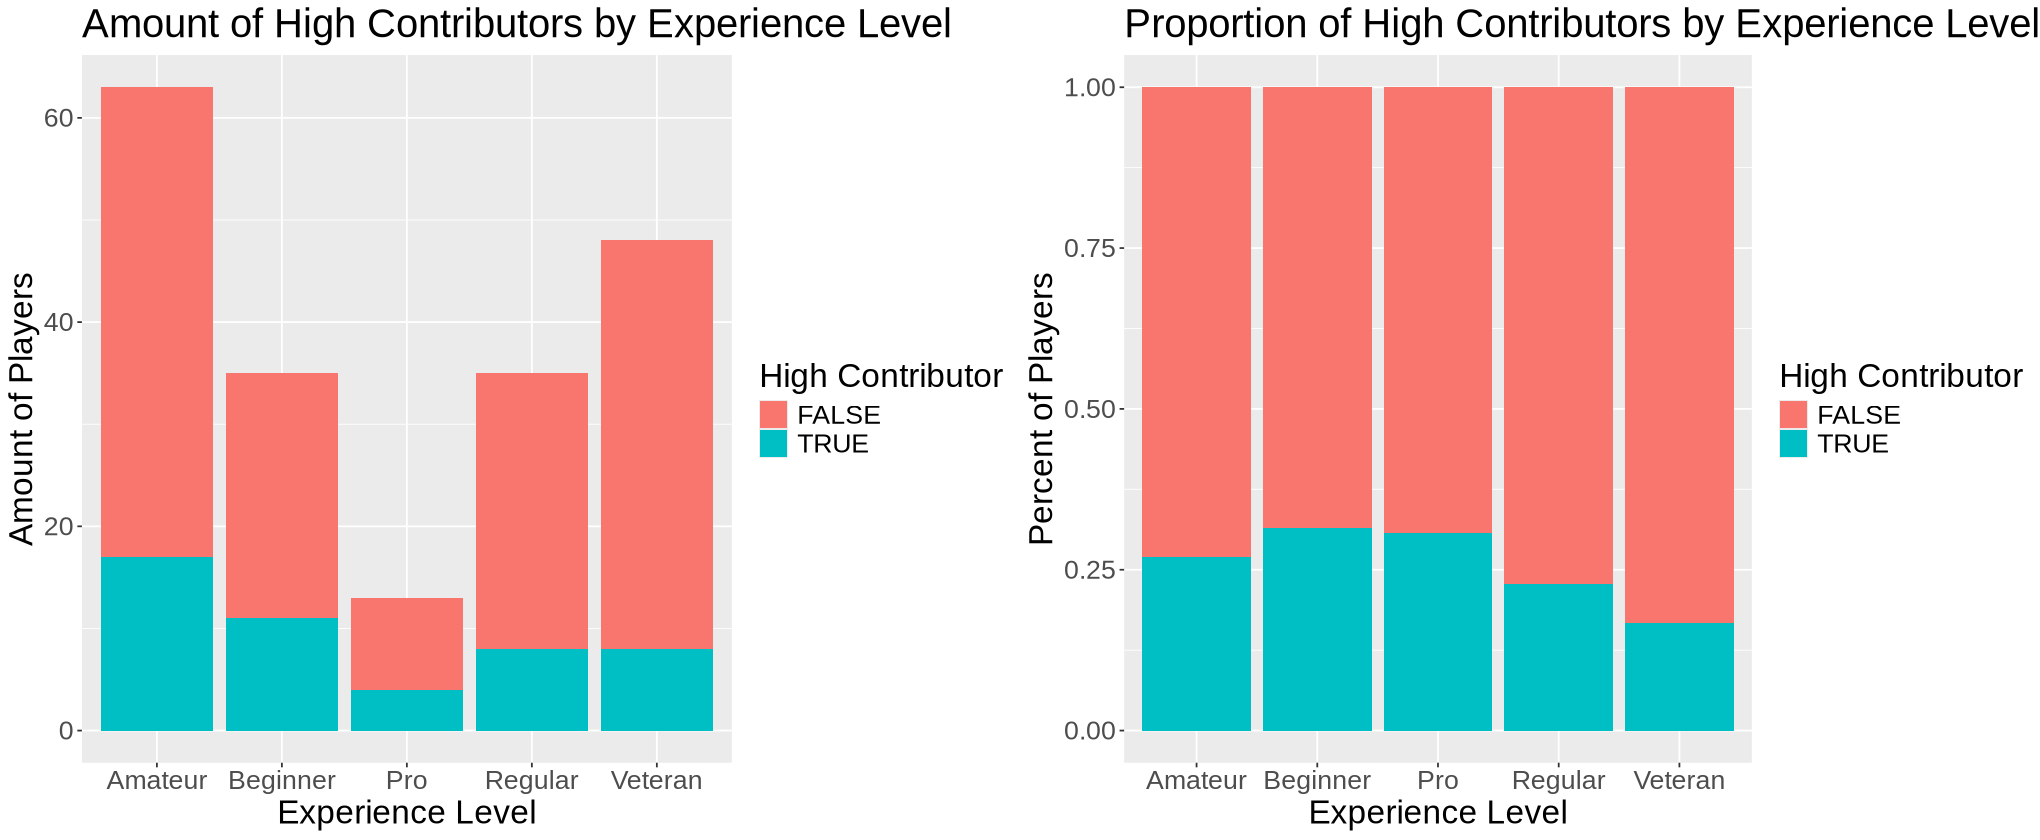

In [35]:
amt_exp_high_contrib <- clean_players |> 
    ggplot(aes(x = experience, fill = high_contributor)) +
        geom_bar(position = "stack") +
        labs(title = "Amount of High Contributors by Experience Level",
             x = "Experience Level",
             y = "Amount of Players",
            fill = "High Contributor") +
        theme(text = element_text(size = 20))

prop_exp_high_contrib <- clean_players |> 
    ggplot(aes(x = experience, fill = high_contributor)) +
        geom_bar(position = "fill") +
        labs(title = "Proportion of High Contributors by Experience Level",
            x = "Experience Level",
            y = "Percent of Players",
            fill = "High Contributor") +
        theme(text = element_text(size = 20))

plot_grid(amt_exp_high_contrib, prop_exp_high_contrib)

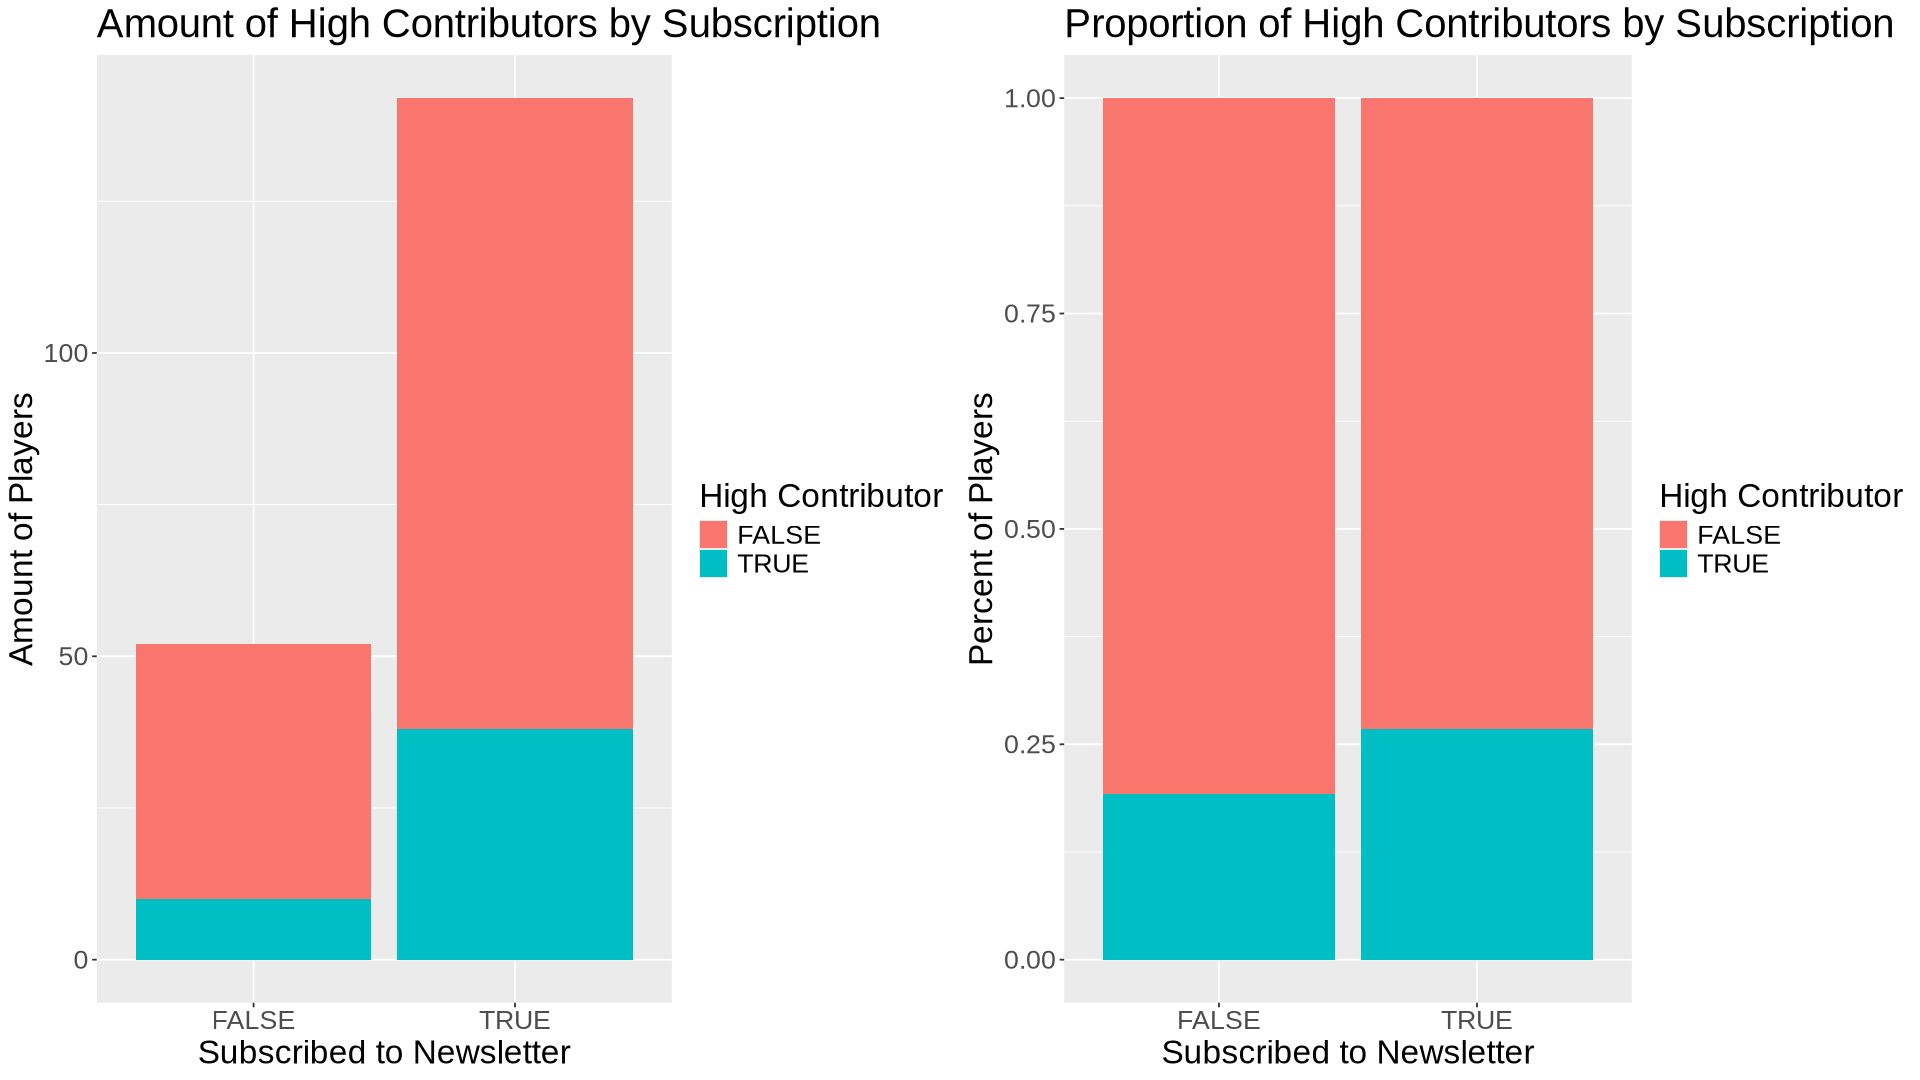

In [42]:
options(repr.plot.width = 16, repr.plot.height = 9)

amt_sub_high_contrib <- clean_players |> 
    ggplot(aes(x = subscribe, fill = high_contributor)) +
        geom_bar(position = "stack") +
        labs(title = "Amount of High Contributors by Subscription",
            x = "Subscribed to Newsletter",
            y = "Amount of Players",
            fill = "High Contributor") +
        theme(text = element_text(size = 20))

prop_sub_high_contrib <- clean_players |> 
    ggplot(aes(x = subscribe, fill = high_contributor)) +
        geom_bar(position = "fill") +
        labs(title = "Proportion of High Contributors by Subscription",
            x = "Subscribed to Newsletter",
            y = "Percent of Players",
            fill = "High Contributor") +
        theme(text = element_text(size = 20))

plot_grid(amt_sub_high_contrib, prop_sub_high_contrib)

In [37]:
mean_hours <- clean_players |>
  pull(played_hours) |>
  mean()

mean_age <- clean_players |>
  pull(Age) |>
  mean()

#mean_hours
#mean_age

In **Code Block 1**, we plot histograms showing the proportion of high contribution players to `age`, `experience`, and `subscribe` (subscription status). These graphs help us visualize patterns present within the data, so we can choose which variables to include in our knn classification model. 

In **Code Block 2**, we first selected the variables we wanted to use, then split the data. We used a 75 - 25 split to determine the ideal K value. We plotted the ideal K values on a graph for easy visualization. It is crucial that we determine the ideal K value, because if we do not do so correctly, we risk over- or under-fitting the data. 

Finally, in **Code Block 3**, we test our model using the "unseen" portion of the data and ideal K value. These tests were run as many times as necessary until a sufficiently accurate model was generated. 

#### Code Block 2:

→ A | warning: !  The following column has zero variance so scaling cannot be used:
                 gender_new.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x2

There were issues with some computations   A: x5





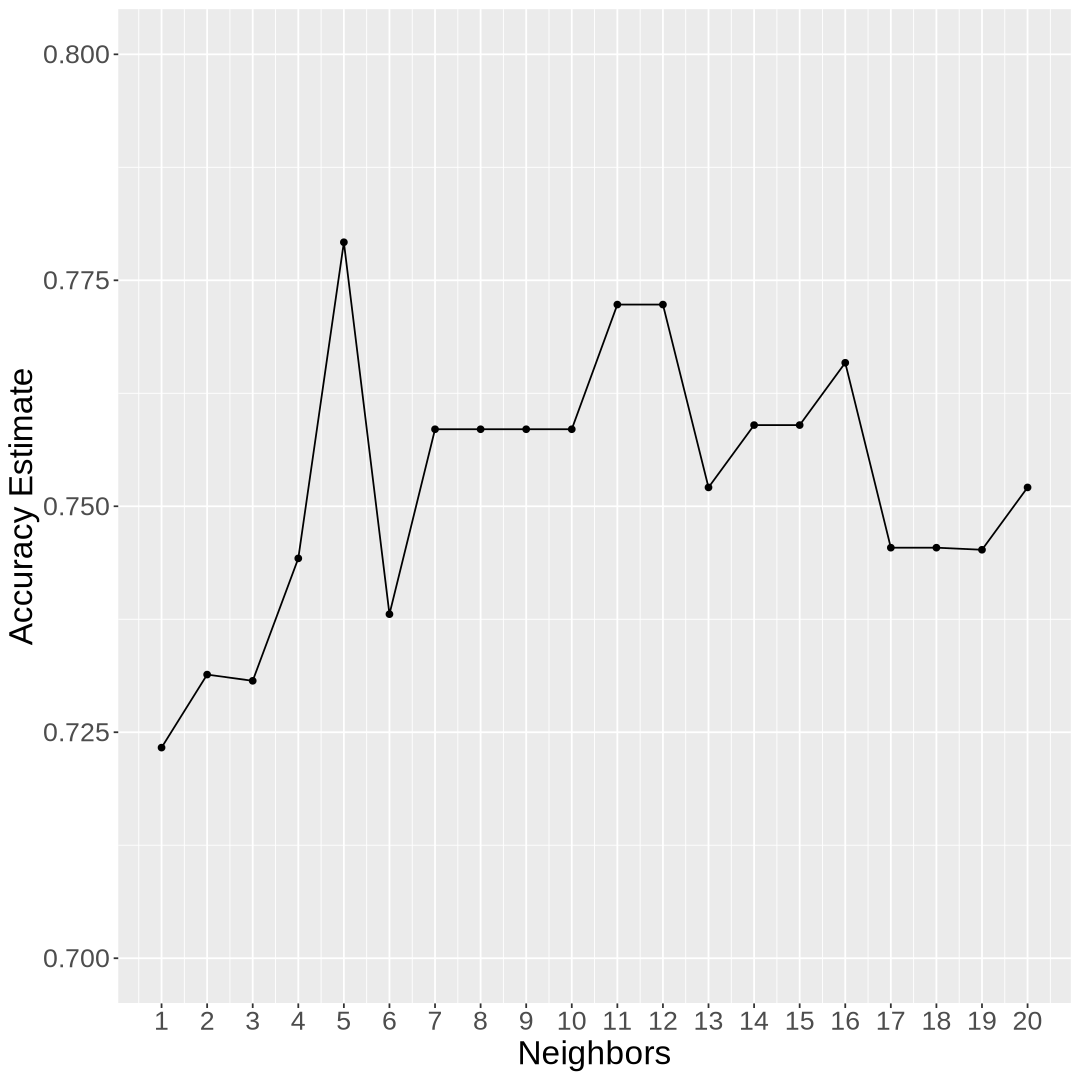

In [9]:
model_data <- clean_players |>
    mutate(high_contributor = as.factor(high_contributor)) |>
    select(high_contributor, Age, experience, subscribe, gender)

set.seed(123)

data_split <- initial_split(model_data, prop = 0.75, strata = high_contributor)

clean_players_training <- training(data_split)
clean_players_testing <- testing(data_split)

knn_recipe <- recipe(high_contributor~., data = clean_players_training) |>
    step_mutate(subscribe = as.integer(subscribe)) |>
    step_mutate(experience = case_match(experience,
        "Beginner" ~ 1,
        "Regular" ~ 2,
        "Amateur" ~ 3,
        "Veteran" ~ 4,
        "Pro" ~ 5)) |>
    step_novel(all_nominal_predictors()) |>
    step_dummy(all_nominal_predictors()) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

knn_spec <- nearest_neighbor(neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

cv_folds <- vfold_cv(clean_players_training, v = 5, strata = high_contributor)

k_grid <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- knn_workflow |> tune_grid(resamples = cv_folds, grid = k_grid) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(1, 20, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.7, 0.8)) + # adjusting the y-axis
      theme(text = element_text(size = 20))
accuracy_versus_k


use K = 11

#### Code Block 3:

In [10]:
knn_best_spec <- nearest_neighbor(neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = clean_players_training)

knn_summary <- knn_best_fit |>
  predict(clean_players_testing) |>
  bind_cols(clean_players_testing) |>
  metrics(truth = high_contributor, estimate = .pred_class) |>
  filter(.metric == 'accuracy')

knn_summary

Warning message:
“!  The following column has zero variance so scaling cannot be used:
  gender_new.
ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
  before normalizing.”
Warning message:
“tune samples were requested but there were 145 rows in the data. 140 will be used.”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.755102


## Discussion
In this project, we defined high contributors as players whose played_hours were above the 75th percentile. Exploratory visualizations revealed to us that older players and those with greater experience were more likely to be high contributors. A subscription to the newsletter is also correlated with increased contribution. 

We trained a k-nearest neighbours classifier using age, experience, subscribe, and gender to predict high contributors. Cross-validation over K=1-20 indicated that K=11 is optimal. The final model achieved an accuracy of ~0.755 on the test set. Some preprocessing warnings indicated features with zero variance, such as gender_new. This contributed no new information but did not prevent model training. Categorical variables were properly encoded, and predictors were all centred and scaled to facilitate distance-based classification. 

These results did align with the expectations, experience, age, and engagement(subscription) are meaningful predictors, but with an accuracy below 80% indicating that predicting high contributors is not trivial. This has practical implications as organizations could use these models to identify likely high contributors for targeted campaigns, but decisions should still account for potential misclassifications.

In the future, we could explore additional behavioural metrics, alternative algorithms, such as random forests, boosting, and feature importance analysis. Investigating class imbalance and predicting future contribution trajectories would further enhance model usage. Overall, the analysis demonstrates that k-NN provides a reasonable baseline while still highlighting areas for improvement and deeper insights into player behaviour. 